# Map of Barcelona signatories 

In [1]:
import requests
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import geopandas as gpd

In [2]:
# URL to the markdown file
url = 'https://raw.githubusercontent.com/cameronneylon/barcelona-declaration-website/main/content/signatories.md'

# Fetch the markdown content from the URL
response = requests.get(url)
md_content = response.text

# Function to parse the markdown lists
def parse_md(md_content):
    groups = re.findall(r'\*\*(.+?)\*\*\n((?:\* .+?\n)+)', md_content)
    data = []

    for group_name, institutions in groups:
        institution_entries = re.findall(r'\* (.+?) \((.+?)\)', institutions)
        for institution, country in institution_entries:
            data.append([institution, country, group_name])

    return pd.DataFrame(data, columns=["institution", "country", "group"])


In [3]:
# Parse the lists in a df and display the first few lines for testing
df = parse_md(md_content)
df.head()

,institution,country,group
0,Aix-Marseille Université,France,Universities and other research performing org...
1,Athena Research Center,Greece,Universities and other research performing org...
2,"Birkbeck, University of London",United Kingdom,Universities and other research performing org...
3,CaixaResearch Institute,Spain,Universities and other research performing org...
4,California Digital Library - CDL,United States of America,Universities and other research performing org...


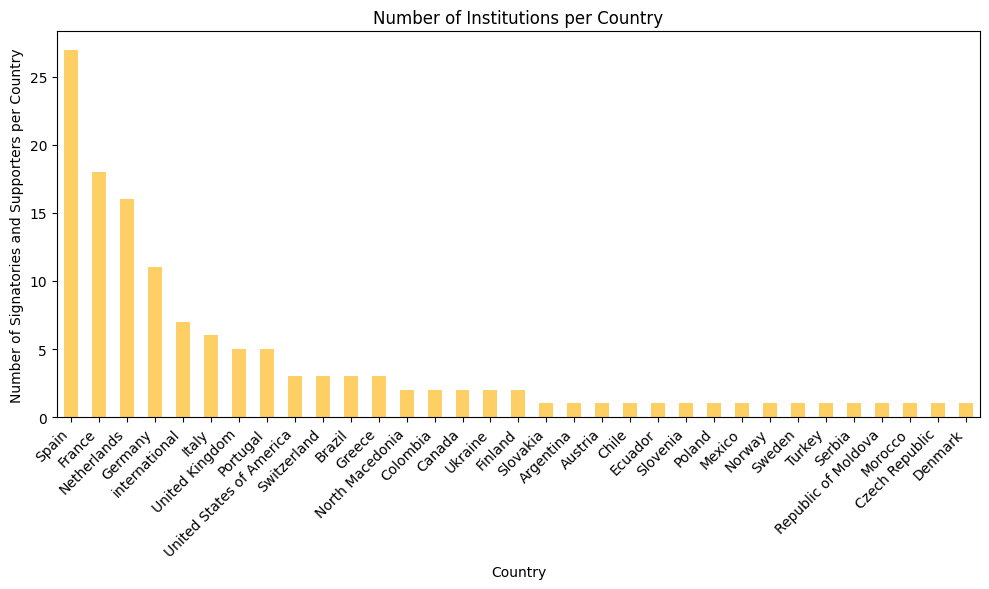

In [4]:
# Count institutions per country
country_counts = df['country'].value_counts()

# Plot barchart
plt.figure(figsize=(10,6))
country_counts.plot(kind='bar', color='#fecf65')

plt.title('Number of Institutions per Country')
plt.xlabel('Country')
plt.ylabel('Number of Signatories and Supporters per Country')
plt.xticks(rotation=45, ha='right')

# Save plot as image. This function only works before displaying the barchart
plt.tight_layout()  
plt.savefig("graphics/BarcelonaDORI_country_barchart.png")  

# Display the barchart
plt.tight_layout()
plt.show()


In [5]:
# Country counts as a table
print(country_counts)

country
Spain                       27
France                      18
Netherlands                 16
Germany                     11
international                7
Italy                        6
United Kingdom               5
Portugal                     5
United States of America     3
Switzerland                  3
Brazil                       3
Greece                       3
North Macedonia              2
Colombia                     2
Canada                       2
Ukraine                      2
Finland                      2
Slovakia                     1
Argentina                    1
Austria                      1
Chile                        1
Ecuador                      1
Slovenia                     1
Poland                       1
Mexico                       1
Norway                       1
Sweden                       1
Turkey                       1
Serbia                       1
Republic of Moldova          1
Morocco                      1
Czech Republic               1


In [6]:
# Custom functions to create gradient color scale for use in geomap
# Using RGB(254, 207, 101) (Mustard yeallow, #fecf65)
# For creating a colormap using two specific colors, see: https://stackoverflow.com/a/67751829

N = 256
vals = np.ones((N,4))

vals[:, 0] = np.linspace(1, 254/256, N)
vals[:, 1] = np.linspace(1, 207/256, N)
vals[:, 2] = np.linspace(1, 101/256, N)

my_cmp = ListedColormap(vals)

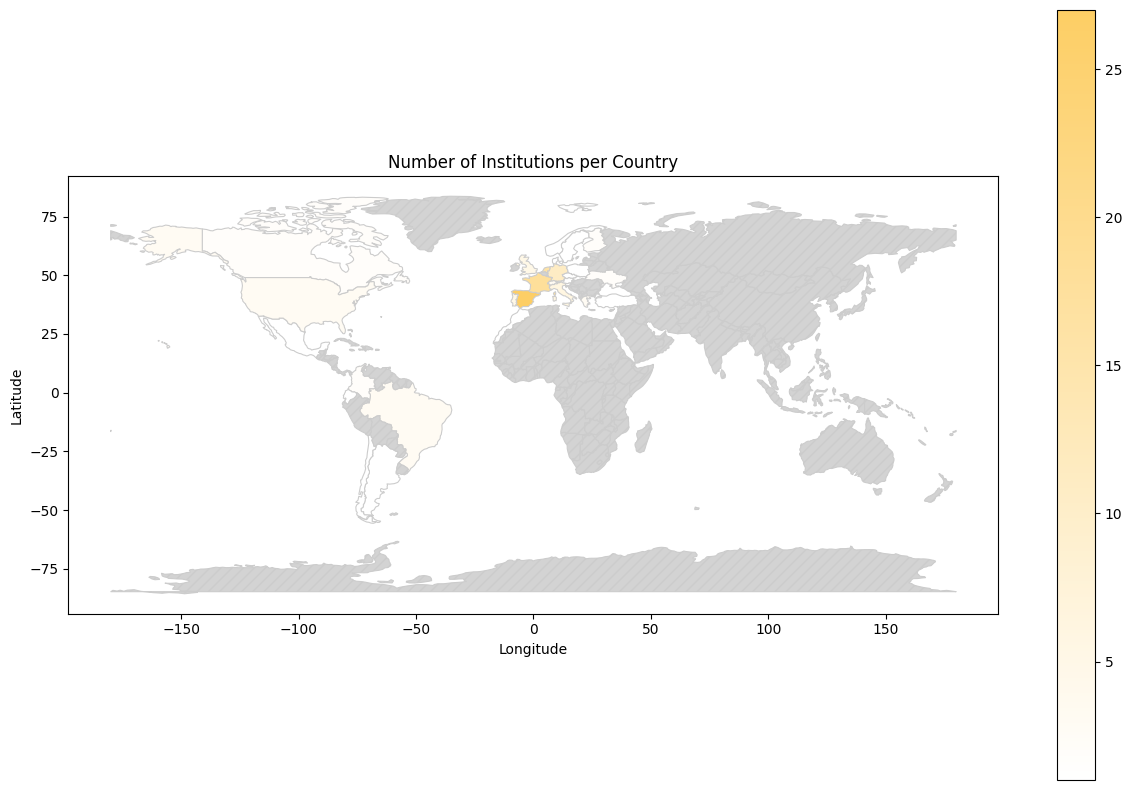

In [7]:
# Load map, thanks to https://github.com/johan for providing this! Finding a working map for geopandas was not easy.
# url = 'https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json'

url = 'countries_geo.json'

world = gpd.read_file(url)

# Merge the world GeoDataFrame with the institution counts
world_data = world.merge(country_counts, how='left', left_on='name', right_on='country')

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the map with color representing the number of institutions (choropleth)
world_data.plot(
    column='count',
    cmap=my_cmp,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    missing_kwds={
        'color': 'lightgrey',  # Color for countries with no data
        'edgecolor': '0.8',
        'hatch': '///',  # Optional hatch pattern
        'label': 'No data'  # Label for the legend
    }
)

# Customize the plot
plt.title('Number of Institutions per Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save plot as image. This function only works before displaying the barchart
plt.savefig("graphics/BarcelonaDORI_country_map.png")  

# Show the map
plt.show()
